In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [124]:
class EWAlg:
    def __init__(self, epsilon, k, h, myBids, myValue):
        self.weights = np.ones(k)
        self.payoffs = np.zeros(k)
        self.h = h
        self.k = k
        self.epsilon = epsilon
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myValue = myValue
        self.myBids = myBids
        self.myTotalValue = 0
        self.allPayoffs = []
        self.regret = 0
        self.rounds = 0

    def getBids(self):
        return self.myBids

    def getValue(self):
        return self.myValue

    def getTotalValue(self):
        return self.myTotalValue

    def getAction(self):
        j = np.random.choice(self.k, 1, p = self.probs)
        self.rounds += 1
        return self.myBids[j.item()]
    
    def getRegret(self):
        payoffMatrix = np.array(self.allPayoffs)
        OPT = payoffMatrix.sum(axis=1).max()
        self.regret = (OPT - self.myTotalValue)/self.rounds
        return self.regret
    
    def update(self, payoffs):
        #update payoffs
        for j in range(len(payoffs)):
            curPayoff = payoffs[j]
            self.payoffs[j] = self.payoffs[j] + curPayoff
        sumPayoffs = np.sum(self.payoffs)   
        # normalize payoffs and calculate new weights
        for j in range(len(payoffs)):
            if (self.payoffs[j] != 0):
                self.payoffs[j] = self.payoffs[j]/sumPayoffs
            newWeight = (1+self.epsilon)**(self.payoffs[j]/self.h)
            self.weights[j] = newWeight
        # normalize weights
        self.sumWeights = np.sum(self.weights)
        self.weights = self.weights/self.sumWeights
        # update probabilities
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        return
    
    def invertProbabilitesAndGetAction(self):
        invProbs = 1/self.probs
        invProbs = invProbs/np.sum(invProbs)
        j = np.random.choice(self.k, 1, p = invProbs)
        return self.myBids[j.item()]

    def generatePayoffs(self, bidToBeat, meWin, price, myQualiity):
        if meWin:
            self.myTotalValue += self.myValue - price
        payoffs = np.zeros(self.k)
        for count, bid in enumerate(self.myBids):
            if (bid * myQualiity) >= bidToBeat:
                payoffs[count] = self.myValue - bid
            else:
                payoffs[count] = 0
        self.allPayoffs.append(payoffs)
        return payoffs
    
    def reset(self):
        self.weights = np.ones(self.k)
        self.payoffs = np.zeros(self.k)
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myTotalValue = 0


In [99]:
class advertiserTracker:
    def __init__(self, index):
        self.index = index
        self.possibleBids =  np.linspace(0, 10, 100)
        self.possibleValues = np.linspace(0, 10, 100)
        self.actualPayoffs = np.zeros(100)
        self.possiblePayoffs = np.zeros((100, 100))
        self.regrets = np.zeros(100)
        self.rounds = 0

    def addPayoffsThisRound(self, bidToBeat, meWin, price, myQuality):
        for count, value in enumerate(self.possibleValues):
            if meWin:
                self.actualPayoffs[count] += value - price
            thisValPayoffs = np.zeros(100)
            for count2, bid in enumerate(self.possibleBids):
                if (bid * myQuality) >= bidToBeat:
                    thisValPayoffs[count2] = value - bid
                else:
                    thisValPayoffs[count2] = 0
            self.possiblePayoffs[count] += thisValPayoffs
        self.rounds += 1
        return
    
    def calcRegrets(self):
        regrets = np.zeros(100)
        for count, value in enumerate(self.possibleValues):
            regrets[count] = self.possiblePayoffs[count].max() - self.actualPayoffs[count]
        self.regrets = regrets / self.rounds
        return 

In [112]:
advertisers = []
trackers = []
actualValues = [0.2, 0.53, 0.78, 0.9]
print("Actual Values:")
for i in range(4):
    myValue = actualValues[i] * 10 # np.random.uniform(0, 1)
    print(myValue)
    # actualValues.append(myValue)
    myBids = np.linspace(0, myValue, 100)
    advertisers.append(EWAlg(0.1, 100, 10, myBids, myValue))
    trackers.append(advertiserTracker(i))

round = [30, 100, 200, 330, 499]
possibleValues = trackers[3].possibleValues
regretsOverTime = np.zeros((len(round), len(possibleValues)))

MSQ = [[0] * 500 for i in range(4)]

for i in range(500):
    bids = []
    qualities = [np.random.uniform(0, 1) for i in range(4)]
    for advertiser in advertisers:
        bids.append(advertiser.getAction())
    qWeightedBids = np.multiply(qualities, bids)
    winningBid = qWeightedBids.max()
    winningBidIndex = qWeightedBids.argmax()
    for count, advertiser in enumerate(advertisers):
        myQuality = qualities[advertisers.index(advertiser)]
        meWin = advertisers.index(advertiser) == winningBidIndex
        payoffs = advertiser.generatePayoffs(winningBid, meWin, bids[winningBidIndex], myQuality)
        advertiser.update(payoffs)
        trackers[count].addPayoffsThisRound(winningBid, meWin, bids[winningBidIndex], myQuality)
        trackers[count].calcRegrets()
        MSQ[count][i] = (actualValues[count] - trackers[count].possibleValues[trackers[count].regrets.argmin()])**2
    bids.clear()
    qualities.clear()
    if(i in round):
        # trackers[3].calcRegrets()
        regretsOverTime[round.index(i)] = trackers[3].regrets



Actual Values:
2.0
5.300000000000001
7.800000000000001
9.0


Estimated Values:
1.7171717171717171
5.555555555555555
8.080808080808081
10.0


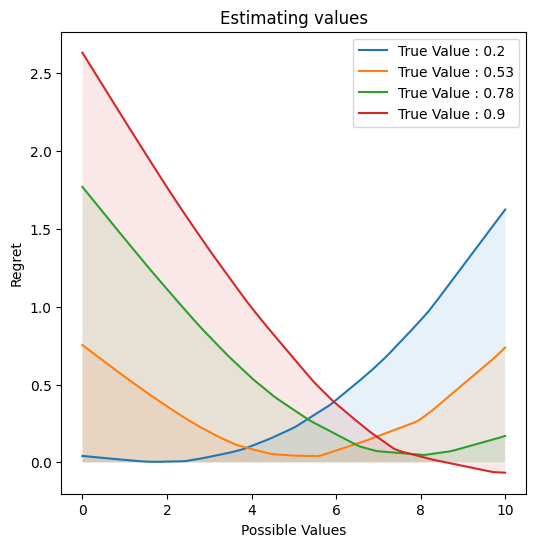

5.252525252525253
10.0
10.0
10.0
10.0


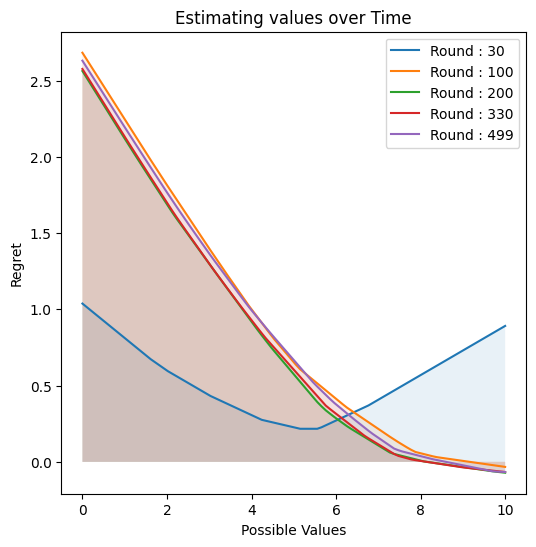

Actual regrets:
0.08145454545454543
0.05449898989898998
-0.19050909090909068
-0.5483636363636352


In [113]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)

print("Estimated Values:")
for count, tracker in enumerate(trackers):
    tracker.calcRegrets()
    print(tracker.possibleValues[tracker.regrets.argmin()])
    #for count, epsilon in enumerate(epsilons):
    plt.plot(tracker.possibleValues, tracker.regrets, label = "True Value : " + str(actualValues[count]))
    plt.fill_between(tracker.possibleValues, tracker.regrets, alpha=.1)

plt.title('Estimating values')
plt.xlabel('Possible Values')
plt.ylabel('Regret')
plt.legend()
plt.show()

f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)

for count in range(5):
    print(possibleValues[regretsOverTime[count].argmin()])
    #for count, epsilon in enumerate(epsilons):
    plt.plot(possibleValues, regretsOverTime[count], label = "Round : " + str(round[count]))
    plt.fill_between(possibleValues, regretsOverTime[count], alpha=.1)

plt.title('Estimating values over Time')
plt.xlabel('Possible Values')
plt.ylabel('Regret')
plt.legend()
plt.show()

print ("Actual regrets:")
for advertiser in advertisers:
    print(advertiser.getRegret())

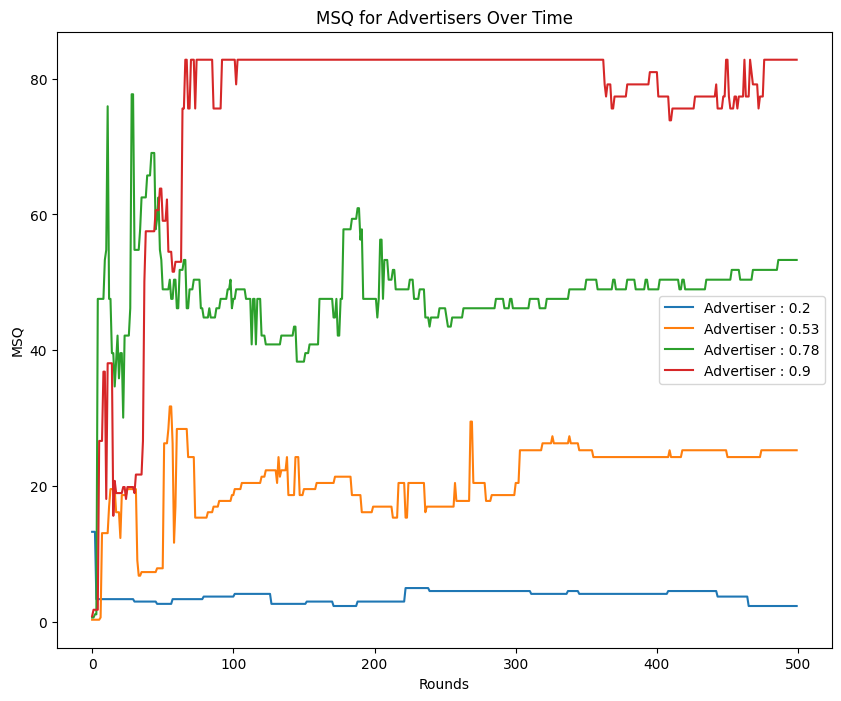

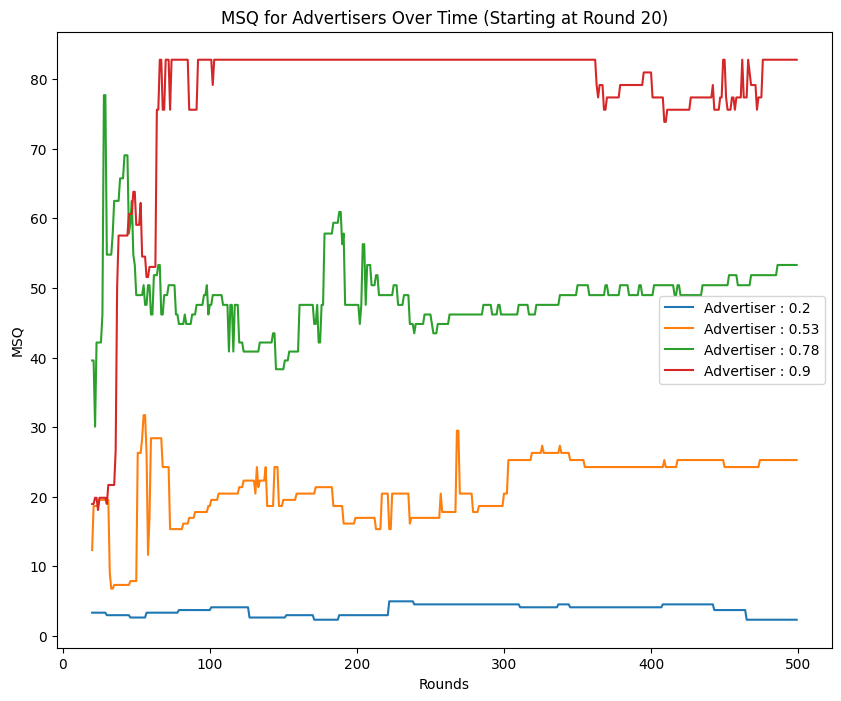

In [114]:
##graphing MSQ
#MSQ = [ [0]*8 for i in range(500)]


f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)

for count in range(4):
    plt.plot(np.arange(500), MSQ[count], label = "Advertiser : " + str(actualValues[count]))

plt.title('MSQ for Advertisers Over Time')
plt.xlabel('Rounds')
plt.ylabel('MSQ')
plt.legend()
plt.show()

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)

for count in range(4):
    plt.plot(np.arange(500)[20:500], MSQ[count][20:500], label = "Advertiser : " + str(actualValues[count]))

plt.title('MSQ for Advertisers Over Time (Starting at Round 20)')
plt.xlabel('Rounds')
plt.ylabel('MSQ')
plt.legend()
plt.show()


# print ("Actual regrets:")
# for advertiser in advertisers:
#     print(advertiser.getRegret())

### Part 2

In [122]:
## step 1: endow values
advertisers = []
trackers = []
actualValues = [0.15, 0.28, 0.37, 0.46, 0.53, 0.65, 0.78, 0.9] # np.random.uniform(0, 1) for i in range(8)
print("Actual Values:")
for i in range(8):
    myValue = actualValues[i] * 10 
    print(myValue)
    myBids = np.linspace(0, myValue, 100)
    advertisers.append(EWAlg(0.068, 100, 1, myBids, myValue))
    trackers.append(advertiserTracker(i))

# round = [30, 100, 200, 330, 499]
# possibleValues = trackers[3].possibleValues
# regretsOverTime = np.zeros((len(round), len(possibleValues)))

# MSQ = [[0] * 500 for i in range(8)]

## step 2 - run the simulation without reserve price
reservePrice = 0
for i in range(500):
    bids = []
    qualities = [np.random.uniform(0, 1) for i in range(8)]
    for advertiser in advertisers:
        bids.append(advertiser.getAction())
    qWeightedBids = np.multiply(qualities, bids)
    winningBid = qWeightedBids.max()
    winningBidIndex = qWeightedBids.argmax()
    newBids = np.delete(qWeightedBids, winningBidIndex)
    if (winningBid < reservePrice):
        winningBid = reservePrice
        winningBidIndex = -1
    secondBid = newBids.max()
    secondBidIndex = newBids.argmax()
    if (secondBid < reservePrice):
        secondBid = reservePrice
        secondBidIndex = -1
    for count, advertiser in enumerate(advertisers):
        myQuality = qualities[advertisers.index(advertiser)]
        if (advertisers.index(advertiser) == winningBidIndex):
            payoffs = advertiser.generatePayoffs(secondBid, True, bids[winningBidIndex], myQuality)
            trackers[count].addPayoffsThisRound(secondBid, True, bids[winningBidIndex], myQuality)
        elif (advertisers.index(advertiser) == secondBidIndex):
            payoffs = advertiser.generatePayoffs(secondBid, True, bids[secondBidIndex], myQuality)
            trackers[count].addPayoffsThisRound(secondBid, True, bids[secondBidIndex], myQuality)
        else:
            payoffs = advertiser.generatePayoffs(secondBid, False, bids[secondBidIndex], myQuality)
            trackers[count].addPayoffsThisRound(secondBid, False, bids[secondBidIndex], myQuality)
        advertiser.update(payoffs)
        #trackers[count].calcRegrets()
        # MSQ[count][i] = (actualValues[count] - trackers[count].possibleValues[trackers[count].regrets.argmin()])**2
    bids.clear()
    qualities.clear()
    # if(i in round):
    #     trackers[3].calcRegrets()
    #     regretsOverTime[round.index(i)] = trackers[3].regrets

##step 3 - infer values
inferredValues = np.zeros(8)
for count, tracker in enumerate(trackers):
    tracker.calcRegrets()
    inferredValues[count] = tracker.possibleValues[tracker.regrets.argmin()]
print(inferredValues)


Actual Values:
1.5
2.8000000000000003
3.7
4.6000000000000005
5.300000000000001
6.5
7.800000000000001
9.0
[1.81818182 2.42424242 3.43434343 4.44444444 5.15151515 6.36363636
 7.17171717 7.57575758]


In [125]:
## step 4 - find optimal reserve price for inferred values
possibleReservePrices = np.linspace(0, 10, 100)
possibleRevenue = np.zeros(100)
testAdvertisers = []
for i in range(8):
    myValue = inferredValues[i]
    myBids = np.linspace(0, myValue, 100)
    testAdvertisers.append(EWAlg(0.1, 100, 1, myBids, myValue))
for count, reservePrice in enumerate(possibleReservePrices):
    for i in range(500):
        bids = []
        qualities = [np.random.uniform(0, 1) for i in range(8)]
        for advertiser in testAdvertisers:
            bids.append(advertiser.getAction())
        qWeightedBids = np.multiply(qualities, bids)
        winningBid = qWeightedBids.max()
        winningBidIndex = qWeightedBids.argmax()
        newBids = np.delete(qWeightedBids, winningBidIndex)
        if (winningBid < reservePrice):
            winningBid = reservePrice
            winningBidIndex = -1
        else:
            possibleRevenue[count] += bids[winningBidIndex]
        secondBid = newBids.max()
        secondBidIndex = newBids.argmax()
        if (secondBid < reservePrice):
            secondBid = reservePrice
            secondBidIndex = -1
        else:
            possibleRevenue[count] += bids[secondBidIndex]
        for count, advertiser in enumerate(advertisers):
            myQuality = qualities[advertisers.index(advertiser)]
            if (advertisers.index(advertiser) == winningBidIndex):
                payoffs = advertiser.generatePayoffs(secondBid, True, bids[winningBidIndex], myQuality)
            elif (advertisers.index(advertiser) == secondBidIndex):
                payoffs = advertiser.generatePayoffs(secondBid, True, bids[secondBidIndex], myQuality)
            else:
                payoffs = advertiser.generatePayoffs(secondBid, False, bids[secondBidIndex], myQuality)
            advertiser.update(payoffs)
        bids.clear()
        qualities.clear()
    for advertiser in testAdvertisers:
        advertiser.reset()
bestReservePrice = possibleReservePrices[possibleRevenue.argmax()]
print(possibleRevenue.max())
print(bestReservePrice)

/var/folders/kb/z6625cjd6pq30cwdbky7yddr0000gn/T/ipykernel_89773/754667123.py:41: RuntimeWarning: overflow encountered in double_scalars
  newWeight = (1+self.epsilon)**(self.payoffs[j]/self.h)
/var/folders/kb/z6625cjd6pq30cwdbky7yddr0000gn/T/ipykernel_89773/754667123.py:48: RuntimeWarning: invalid value encountered in true_divide
  self.weights = self.weights/self.sumWeights
/var/folders/kb/z6625cjd6pq30cwdbky7yddr0000gn/T/ipykernel_89773/754667123.py:51: RuntimeWarning: invalid value encountered in true_divide
  self.probs = self.weights/self.sumWeights


KeyboardInterrupt: 

In [102]:
reservePrice = 0.7070707070707071
revenue = 0
for advertiser in advertisers:
    advertiser.reset()
for i in range(500):
    bids = []
    qualities = [np.random.uniform(0, 1) for i in range(8)]
    for advertiser in advertisers:
        bids.append(advertiser.getAction())
    qWeightedBids = np.multiply(qualities, bids)
    winningBid = qWeightedBids.max()
    winningBidIndex = qWeightedBids.argmax()
    newBids = np.delete(qWeightedBids, winningBidIndex)
    if (winningBid < reservePrice):
        winningBid = reservePrice
        winningBidIndex = -1
    else:
        revenue += bids[winningBidIndex]
    secondBid = newBids.max()
    secondBidIndex = newBids.argmax()
    if (secondBid < reservePrice):
        secondBid = reservePrice
        secondBidIndex = -1
    else:
        revenue += bids[secondBidIndex]
    for count, advertiser in enumerate(advertisers):
        myQuality = qualities[advertisers.index(advertiser)]
        if (advertisers.index(advertiser) == winningBidIndex):
            payoffs = advertiser.generatePayoffs(secondBid, True, bids[winningBidIndex], myQuality)
            #trackers[count].addPayoffsThisRound(secondBid, True, bids[winningBidIndex], myQuality)
        elif (advertisers.index(advertiser) == secondBidIndex):
            payoffs = advertiser.generatePayoffs(secondBid, True, bids[secondBidIndex], myQuality)
            #trackers[count].addPayoffsThisRound(secondBid, True, bids[secondBidIndex], myQuality)
        else:
            payoffs = advertiser.generatePayoffs(secondBid, False, bids[secondBidIndex], myQuality)
            #trackers[count].addPayoffsThisRound(secondBid, False, bids[secondBidIndex], myQuality)
        advertiser.update(payoffs)
        #trackers[count].calcRegrets()
        # MSQ[count][i] = (actualValues[count] - trackers[count].possibleValues[trackers[count].regrets.argmin()])**2
    bids.clear()
    qualities.clear()
print(revenue)

5033.205050505048
